In [2]:
import os
from torchvision.datasets import CocoDetection
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
import time



In [3]:

print(torch.version.cuda)
print(torch.backends.cuda.is_built())

12.6
True


In [4]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_built() and torch.backends.mps.is_available():
    device = torch.device("mps")
print(device)


cuda


In [5]:
#RAHHH I LOVE TUTORIALS: https://docs.pytorch.org/tutorials/intermediate/torchvision_tutorial.html (thanks for the guide)
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#in_features = model.roi_heads.box_predictor.cls_score.in_features
#model.roi_heads.box_predictor = FastRCNNPredictor(in_features,  weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT, num_classes=2)
model = fasterrcnn_resnet50_fpn(
    weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT,
)
model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            

In [6]:
print("Using device:", device)
print("Model lives on:", next(model.parameters()).device)

Using device: cuda
Model lives on: cuda:0


In [7]:
from helper import customCoco
from helper import collate

transform = transforms.Compose([
    transforms.ToTensor(),
])
    
X_train = "../data/license_plates/train/images"
y_train = "../data/license_plates/train/annotations.json"

train_dataset = customCoco(root=X_train, annFile=y_train, size=(128, 128), transform=transform)
#for the next one, try to make collate_fn work somehow so i can keep origional image size but its just not working for now
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, prefetch_factor=2, persistent_workers=True, collate_fn=collate)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


[{'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [60.20338983050848, 90.4026402640264, 26.576271186440678, 13.518151815181518], 'area': 3136, 'segmentation': [], 'iscrowd': 0}]


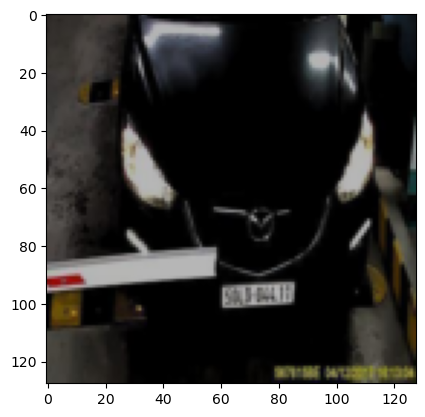

[tensor([[[0.5255, 0.5294, 0.5412,  ..., 0.4431, 0.4039, 0.4078],
         [0.5255, 0.5255, 0.5373,  ..., 0.4392, 0.4275, 0.4235],
         [0.5216, 0.5255, 0.5294,  ..., 0.4588, 0.4392, 0.4314],
         ...,
         [0.7961, 0.7608, 0.5608,  ..., 0.7843, 0.8902, 0.7882],
         [0.7961, 0.7529, 0.5608,  ..., 0.7137, 0.7804, 0.7176],
         [0.8000, 0.7451, 0.5569,  ..., 0.6941, 0.6941, 0.6745]],

        [[0.5373, 0.5412, 0.5529,  ..., 0.4353, 0.4000, 0.4039],
         [0.5373, 0.5373, 0.5490,  ..., 0.4314, 0.4235, 0.4196],
         [0.5333, 0.5373, 0.5412,  ..., 0.4471, 0.4353, 0.4275],
         ...,
         [0.7255, 0.6902, 0.4980,  ..., 0.7961, 0.8627, 0.7529],
         [0.7333, 0.6824, 0.4941,  ..., 0.7333, 0.7490, 0.6941],
         [0.7333, 0.6745, 0.4902,  ..., 0.6941, 0.6824, 0.6863]],

        [[0.5725, 0.5765, 0.5882,  ..., 0.4667, 0.4235, 0.4275],
         [0.5725, 0.5725, 0.5843,  ..., 0.4667, 0.4471, 0.4431],
         [0.5686, 0.5725, 0.5765,  ..., 0.4863, 0.4588, 0

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

img, target = train_dataset[0]


fig, ax = plt.subplots(1)
ax.imshow(img.permute(1, 2, 0))  # Convert from [C,H,W] to [H,W,C]
print(target)

plt.show()

In [20]:
#SKIP THIS STEP. mostly for when i was perma stuck on training with mps. switched to cpu instead for m3
loader = train_loader
t0 = time.time()
batch = next(iter(loader))
t1 = time.time()
print(f"Loaded 1 batch in {t1-t0:.2f}s")
imgs, targs = batch

t0 = time.time()
imgs_gpu = [img.to(device) for img in imgs]
for t in targs:
    t['boxes']  = t['boxes'].to(device)
    t['labels'] = t['labels'].to(device)
t1 = time.time()
print(f"Move→GPU: {t1-t0:.2f}s")
t0 = time.time()
_ = model(imgs_gpu, targs)
t1 = time.time()
print(f"Forward (single batch): {t1-t0:.2f}s")

Loaded 1 batch in 0.02s
Move→GPU: 0.00s
Forward (single batch): 0.29s


In [8]:
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=2, min_lr=1e-7
)


epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    epoch_loss   = 0.0
    i = 0
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        for t in targets:
            t['boxes']  = t['boxes'].to(device)
            t['labels'] = t['labels'].to(device)
        
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_val = loss.item()
        running_loss += loss_val
        epoch_loss   += loss_val

        if i % 50 == 0 or i == len(train_loader):
            print(f"[{epoch+1}/{epochs}, {i:5d}] "
                  f"loss/50 = {running_loss/50:.4f} | "
                  f"LR = {optimizer.param_groups[0]['lr']:.2e}")
            running_loss = 0.0
        i += 1
        
    scheduler.step(epoch_loss / len(train_loader))
    print(f"Epoch {epoch+1} finished - avg loss: {epoch_loss/len(train_loader):.4f}\n")

[1/5,     0] loss/50 = 0.0084 | LR = 1.00e-04
[1/5,    50] loss/50 = 0.1385 | LR = 1.00e-04
[1/5,   100] loss/50 = 0.0982 | LR = 1.00e-04
[1/5,   150] loss/50 = 0.0861 | LR = 1.00e-04
[1/5,   200] loss/50 = 0.0878 | LR = 1.00e-04
[1/5,   250] loss/50 = 0.0844 | LR = 1.00e-04
[1/5,   300] loss/50 = 0.0906 | LR = 1.00e-04
[1/5,   350] loss/50 = 0.0876 | LR = 1.00e-04
[1/5,   400] loss/50 = 0.0880 | LR = 1.00e-04
[1/5,   450] loss/50 = 0.0932 | LR = 1.00e-04
[1/5,   500] loss/50 = 0.0835 | LR = 1.00e-04
[1/5,   550] loss/50 = 0.0772 | LR = 1.00e-04
[1/5,   600] loss/50 = 0.1022 | LR = 1.00e-04
[1/5,   650] loss/50 = 0.0743 | LR = 1.00e-04
[1/5,   700] loss/50 = 0.0784 | LR = 1.00e-04
[1/5,   750] loss/50 = 0.0768 | LR = 1.00e-04
[1/5,   800] loss/50 = 0.0806 | LR = 1.00e-04
[1/5,   850] loss/50 = 0.0809 | LR = 1.00e-04
[1/5,   900] loss/50 = 0.0797 | LR = 1.00e-04
[1/5,   950] loss/50 = 0.0717 | LR = 1.00e-04
[1/5,  1000] loss/50 = 0.0777 | LR = 1.00e-04
[1/5,  1050] loss/50 = 0.0993 | LR

In [9]:
X_test = "../data/license_plates/test/images"
y_test = "../data/license_plates/test/annotations.json"

test_dataset = customCoco(root=X_test, annFile=y_test, size=(128, 128), transform=transform)
#for the next one, try to make collate_fn work somehow so i can keep origional image size but its just not working for now
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=4, prefetch_factor=2, persistent_workers=True, collate_fn=collate)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [38]:
img, target = test_dataset[4]
model.eval()
with torch.no_grad():
    pred = model([img.to(device)])[0]
    pred = {k: v.cpu() for k, v in pred.items()}
print(target)

[{'id': 4, 'image_id': 4, 'category_id': 1, 'bbox': [56.13559322033898, 91.24752475247524, 27.93220338983051, 11.405940594059405], 'area': 2781, 'segmentation': [], 'iscrowd': 0}]


In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def viz_single_prediction(img,
                          target: dict,
                          prediction: dict,
                          gt_color="lime",
                          pred_color="red"):
    """
    Args
    ----
    img        : PIL image *or* torch.Tensor shaped (C,H,W) in [0,1]
    target     : dict with key 'boxes' (N,4) in xyxy *(and optionally 'labels')*
    prediction : dict with key 'boxes' (M,4) in xyxy
    """
    target = target[0]

    # --- convert tensor -> PIL so Matplotlib can show it --------------
    if isinstance(img, torch.Tensor):
        img = to_pil_image(img.cpu())

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    ax = plt.gca()

    # --- ground-truth --------------------------------------------------
    box = target["bbox"]
    print(box)
    x1, y1, x2, y2 = box
    ax.add_patch(
        plt.Rectangle((x1, y1),
                        x2 - x1,
                        y2 - y1,
                        fill=False,
                        edgecolor=gt_color,
                        linewidth=2)
    )

    # --- prediction ----------------------------------------------------
    for box in prediction["boxes"]:
        x1, y1, x2, y2 = box.tolist()
        ax.add_patch(
            plt.Rectangle((x1, y1),
                          x2 - x1,
                          y2 - y1,
                          fill=False,
                          linestyle="--",
                          edgecolor=pred_color,
                          linewidth=2)
        )

    plt.axis("off")
    plt.show()

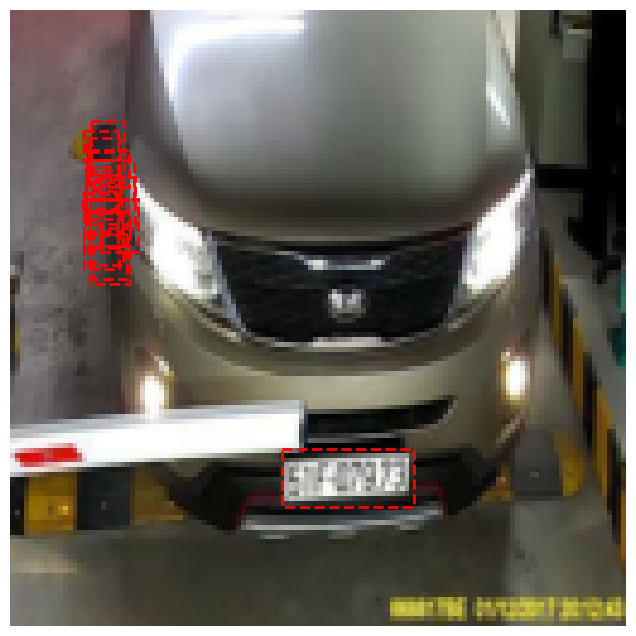

In [42]:
viz_single_prediction(img, target, pred)